# **Đường dẫn thư mục chứa tập tin Graph.csv**

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
folder = "/content/gdrive/MyDrive/Năm 3/05. LTPTDL/LTPTDL - Đồ án cuối kỳ/Data"

Mounted at /content/gdrive


# **Thư viện**

In [ ]:
import numpy as np
import csv
import networkx as nx
import matplotlib.pyplot as plt
import heapq
import time
import random

# **Xây dựng các lớp**

---
## **Lớp Priority Queue**
---

In [ ]:
class PriorityQueue:
    def __init__(self):
        self.queue = []
        self.priorities = {}  # key là item, value là điểm priority
        self.index = 0   # Index dùng để lưu thứ tự add vào queue của các item có cùng priority
        self.DONE = -100000

    def insert(self, newPriority, item):
        """Thêm item cùng với điểm priority vào queue"""
        # heapq theo mặc định là min-heap nên nó sẽ tự động giữ phần tử có điểm priority thấp nhất ở trên cùng
        # Sử dụng `self._index` để giữ thứ tự chèn cho các phần tử có cùng điểm priority
        oldPriority = self.priorities.get(item)
        if oldPriority is None or newPriority < oldPriority:
            self.priorities[item] = newPriority
            heapq.heappush(self.queue, (newPriority, self.index, item))
            self.index += 1
            return True
        return False

    def removeMin(self):
        """Trả về item có điểm priority nhỏ nhất ra khỏi queue"""
        while len(self.queue) > 0:
            priority, _, item = heapq.heappop(self.queue)
            if self.priorities[item] == self.DONE:
                continue  # Outdated priority, skip
            self.priorities[item] = self.DONE
            return item
        return None  # Nothing left...

    def empty(self):
        """Trả về True nếu tất cả item trong queue đều có Priority là DONE"""
        for i in self.priorities:
            if self.priorities[i] != self.DONE:
                return False
        return True

    def __str__(self):
        return f"{self.queue}"

    def __repr__(self):
        return f"{self.queue}"

---
## **Lớp biểu diễn cạnh của đồ thị**
---

In [ ]:
class Edge:
    def __init__(self, node_start, node_end, cost):
        self.node_start = node_start
        self.node_end = node_end
        self.cost = cost

    def __str__(self):
        return f"{self.node_start} <--> {self.node_end}: {self.cost}"

    def __repr__(self):
        return f"{self.node_start} <--> {self.node_end}: {self.cost}"

    def __eq__(self, other):
        return self.node_start == other.node_start and self.node_end == other.node_end and self.cost == other.cost

    def __hash__(self):
        return hash((self.node_start, self.node_end, self.cost))

---
## **Lớp biểu diễn bài toán tìm đường đi ngắn nhất trên đồ thị**
---
Sử dụng thuật toán Dijkstra.
1. Tìm đường đi ngắn nhất từ 1 đỉnh bắt đầu đến đỉnh đích theo yêu cầu
2. Tìm đường đi ngắn nhất từ 1 đỉnh bắt đầu đến tất cả các đỉnh còn lại

Tạo đồ thị dùng 2 cách:
1. Tạo instance **GraphProblem** và chỉ định argument *file_path* để đọc đồ thị từ file có định dạng CSV như sau:
```
        v_from, v_to, weight
```
2. Tạo đồ thị ngẫu nhiên với số đỉnh và số cạnh theo yêu cầu dùng class method *generate_graph()* với 2 arguments: *num_nodes*, *num_edges*

In [ ]:
class GraphProblem:
    def __init__(self, file_path=None, start_node=None, goal_nodes=[], adjacency_list={}, edges=[], nodes=[]):

        self.adjacency_list = adjacency_list
        self.edges = edges
        self.nodes = nodes
        self.start_node = start_node
        self.goal_nodes = goal_nodes

        if file_path is not None:
            self.read_graph(file_path)


    def read_graph(self, file_path):
        self.adjacency_list = {}
        self.edges = []
        self.nodes = []
        with open(file_path) as file:
            lines = csv.DictReader(file)
            for line in lines:
                node_start = line["v_from"]
                node_end = line["v_to"]
                if float(line["weight"]) > 0:
                    edge = Edge(node_start=node_start, node_end=node_end, cost=float(line["weight"]))
                else:
                    raise ValueError("Dijkstra không hoạt động chính xác với đồ thị trọng số âm!")


                if node_start not in self.nodes:
                    self.nodes.append(node_start)
                    self.adjacency_list[node_start] = []
                if node_end not in self.nodes:
                    self.nodes.append(node_end)
                    self.adjacency_list[node_end] = []

                # Thêm cạnh vào danh sách kề (adjacency list) (cho graph vô hướng)
                self.adjacency_list[node_start].append(node_end)
                self.adjacency_list[node_end].append(node_start)

                self.edges.append(edge)

    @classmethod
    def generate_graph(cls, num_nodes, num_edges):
        """Tạo ra 1 đồ thị ngẫu nhiên với số đỉnh và số cạnh cho trước"""

        adjacency_list = {}

        # Thêm đỉnh vào danh sách đỉnh
        nodes = [f"v{i}" for i in range(num_nodes)]
        for node in nodes:
            adjacency_list[node] = []

        # Thêm cạnh một cách ngẫu nhiên cho đến khi số cạnh thỏa mãn yêu cầu
        edges = []
        while len(edges) < num_edges:
            # Chọn ngẫu nhiên 2 đỉnh
            node1 = random.choice(nodes)
            node2 = random.choice(nodes)

            # Thêm cạnh nếu 2 đỉnh khác nhau và giữa 2 đỉnh chưa tồn tại cạnh nổi
            if node1 != node2 and not any((e.node_start == node1 and e.node_end == node2) or
                                          (e.node_start == node2 and e.node_end == node1) for e in edges):
                cost = random.randint(1, 10)  # Gán cost cho cạnh ngẫu nhiên từ 1 đến 10
                edge = Edge(node_start=node1, node_end=node2, cost=cost)
                edges.append(edge)

                # Thêm đỉnh được nối vào danh sách kề
                adjacency_list[node1].append(node2)
                adjacency_list[node2].append(node1)

        start_node = random.choice(nodes)  # Chọn đỉnh bắt đầu ngẫu nhiên

        # Tạo GraphProblem instance
        graph_problem = cls(adjacency_list=adjacency_list, edges=edges, nodes=nodes, start_node=start_node)

        return graph_problem

    def __str__(self):
        return f"GraphProblem(adjacency_list={self.adjacency_list}\nEdges={self.edges}\nNodes={self.nodes}\nStart_node={self.start_node}\nGoal_node={self.goal_nodes})"

    def get_nodes(self):
        """Trả về danh sách các đỉnh của đồ thị"""
        return self.nodes

    def get_edges(self):
        """Trả về danh sách các cạnh của đồ thị"""
        return self.edges

    def get_neighbors(self, node):
        """Trả về danh sách các đỉnh kề của đỉnh node"""
        return self.adjacency_list[node]

    def is_goal(self, node):
        """Kiểm tra xem đỉnh node có phải là đỉnh đích hay không"""
        return node in self.goal_nodes

    def get_cost(self, node_start, node_end):
        """Trả về cost của cạnh nối node_start và node_end"""
        for edge in self.edges:
            if (((edge.node_start == node_start) and (edge.node_end == node_end)) or
                ((edge.node_start == node_end) and (edge.node_end == node_start))):
                return edge.cost
        return None

    def dijkstra(self):
        """Tìm đường đi ngắn nhất từ đỉnh bắt đầu đến một trong các đỉnh đích"""
        Q = PriorityQueue()
        S = set() # Explored set
        d = {} # dictionary lưu khoảng cách ngắn nhất đến các đỉnh
        previous = {} # dictionary lưu đỉnh trước đó (parent) của các đỉnh

        for node in self.nodes:
            d[node] = float("inf") # gán khoảng cách ngắn nhất đến tất cả các đỉnh bằng vô cực
            previous[node] = None # parent của tất cả các đỉnh ban đầu bằng None

        Q.insert(0, self.start_node) # Thêm đỉnh bắt đầu với priority = 0 vào hàng đợi
        d[self.start_node] = 0 # Đầu tiên, gán khoảng cách đến đỉnh bắt đầu bằng 0

        while not Q.empty():
            u = Q.removeMin() # Lấy đỉnh u ở phía đầu Priority Queue (đỉnh có khoảng cách ngắn nhất)
            S.add(u) # Đánh dấu đỉnh u là "explored" bằng cách thêm đỉnh u vào Explored set

            if self.is_goal(u): # Nếu đỉnh u nằm trong đỉnh đích
                path = self.reconstruct_path(previous, u) # Lấy đường đi đến u bằng cách lần theo các đỉnh parent
                cost = d[u]  # Lấy cost của đường đi trong distance dictionary
                return path, cost # Trả về đường đi ngắn nhất và cost của đường đi đó
                # Dừng thuật toán khi tìm thấy đường đi ngắn nhất đến một trong số các đỉnh đích

            for v in self.get_neighbors(u): # Duyệt qua các đỉnh kề với đỉnh u (gọi là đỉnh v)
                if v in S: # Nếu đỉnh v đã được đánh dấu là "explored"
                    continue # => Tiếp tục xét đỉnh kề khác của đỉnh u

                alt = d[u] + self.get_cost(u, v) # Tính cost mới của v bằng cách lấy cost của u cộng cost từ u đến v, lưu cost mới của v vào 1 biến tạm là alt

                if alt < d[v]: # Nếu cost mới của v nhỏ hơn cost của v đã lưu trước đó
                    d[v] = alt # Lưu cost của v thành cost mới
                    Q.insert(alt, v) # Thêm v và cost mới của v vào hàng đợi
                    previous[v] = u # Lưu parent của v là u

        return None, float("inf")


    def dijkstra_all_paths(self):
        """Tìm đường đi ngắn nhất từ đỉnh bắt đầu đến tất cả các đỉnh còn lại"""
        Q = PriorityQueue()
        S = set()  # Explored set
        d = {}  # dictionary lưu khoảng cách ngắn nhất đến các đỉnh
        previous = {}  # dictionary lưu đỉnh trước đó (parent) của các đỉnh

        for node in self.nodes:
            d[node] = float("inf") # gán khoảng cách ngắn nhất đến tất cả các đỉnh bằng vô cực
            previous[node] = None # parent của tất cả các đỉnh ban đầu bằng None

        Q.insert(0, self.start_node) # Thêm đỉnh bắt đầu với priority = 0 vào hàng đợi
        d[self.start_node] = 0  # Đầu tiên, gán khoảng cách đến đỉnh bắt đầu bằng 0

        while not Q.empty():
            u = Q.removeMin()  # Lấy đỉnh u ở phía đầu Priority Queue (đỉnh có khoảng cách ngắn nhất)
            S.add(u)  # Đánh dấu đỉnh u là "explored" bằng cách thêm đỉnh u vào Explored set

            # Không dừng lại khi đến đỉnh đích
            # Thay vào đó, tiếp tục cho đến khi Priority Queue rỗng

            for v in self.get_neighbors(u): # Duyệt qua các đỉnh kề với đỉnh u (gọi là đỉnh v)
                if v in S: # Nếu đỉnh v đã được đánh dấu là "explored"
                    continue # => Tiếp tục xét đỉnh kề khác của đỉnh u

                alt = d[u] + self.get_cost(u, v) # Tính cost mới của v bằng cách lấy cost của u cộng cost từ u đến v, lưu cost mới của v vào 1 biến tạm là alt

                if alt < d[v]: # Nếu cost mới của v nhỏ hơn cost của v đã lưu trước đó
                    d[v] = alt # Lưu cost của v thành cost mới
                    Q.insert(alt, v) # Thêm v và cost mới của v vào hàng đợi
                    previous[v] = u # Lưu parent của v là u

        # 'd' chứa khoảng cách ngắn nhất tới tất cả các nút
        # Reconstruct paths to all nodes
        all_paths = {}
        for node in self.nodes:
            if node != self.start_node:  # Exclude the start node itself
                all_paths[node] = self.reconstruct_path(previous, node)

        return all_paths, d  # Trả về all_paths và dictionary 'd'

    def reconstruct_path(self, previous, u):
        path = []
        while u is not None:
            path.append(u)
            u = previous[u]
        path.reverse()     # Đảo ngược để có đường đi từ start đến u
        return path

    def draw_graph(self, fixed_positions=None):
        graph = nx.Graph()

        for node in self.nodes:
            graph.add_node(node)
        for edge in self.edges:
            graph.add_edge(edge.node_start, edge.node_end, weight=edge.cost)

        plt.figure(figsize=(8, 4))
        # Dùng spring_layout với fixed positions (nếu có)
        if fixed_positions is not None:
            pos = nx.spring_layout(graph, pos=fixed_positions, fixed=fixed_positions.keys())
        else:
            pos = nx.kamada_kawai_layout(graph)

        nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=nx.get_edge_attributes(graph, 'weight'))
        plt.title("Đồ thị ban đầu")
        plt.show()

    def draw_path(self, path, fixed_positions=None):
        graph = nx.Graph()

        for node in self.nodes:
            graph.add_node(node)
        for edge in self.edges:
            graph.add_edge(edge.node_start, edge.node_end, weight=edge.cost)

        # Lấy danh sách cạnh của đường đi
        edge_list = []
        for i in range(len(path) - 1):
            edge_list.append((path[i], path[i + 1]))

        # Tạo list màu cho các node
        node_colors = []
        for node in graph.nodes():
            if node in path:  # Kiểm tra xem node có trong đường đi hay không
                node_colors.append('red')  # Tô màu đỏ cho node trong đường đi
            else:
                node_colors.append('lightblue')  # Tô màu hồng cho các node khác

        plt.figure(figsize=(8, 4))
        # Dùng spring_layout với fixed positions
        if fixed_positions is not None:
            pos = nx.spring_layout(graph, pos=fixed_positions, fixed=fixed_positions.keys())
        else:
            pos = nx.kamada_kawai_layout(graph)
        nx.draw(graph, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=10)
        nx.draw_networkx_edges(graph, pos, edgelist=edge_list, edge_color='red', width=2, arrows=True, arrowstyle='->', arrowsize=20)
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=nx.get_edge_attributes(graph, 'weight'))
        plt.title(f"Đường đi từ {edge_list[0][0]} đến {edge_list[-1][-1]}")
        plt.show()


# **Danh sách các đỉnh và cạnh của đồ thị ban đầu**

______________________________________________________________________

Danh sách các node:
______________________________________________________________________

1)	v0
2)	v1
3)	v7
4)	v2
5)	v3
6)	v5
7)	v8
8)	v4
9)	v6

______________________________________________________________________

Danh sách các cạnh:
______________________________________________________________________

1)	v0 <--> v1: 4.0
2)	v0 <--> v7: 8.0
3)	v1 <--> v2: 8.0
4)	v1 <--> v7: 11.0
5)	v2 <--> v3: 7.0
6)	v2 <--> v5: 4.0
7)	v2 <--> v8: 2.0
8)	v3 <--> v4: 9.0
9)	v3 <--> v5: 14.0
10)	v4 <--> v5: 10.0
11)	v5 <--> v6: 2.0
12)	v6 <--> v7: 1.0
13)	v6 <--> v8: 6.0
14)	v7 <--> v8: 7.0



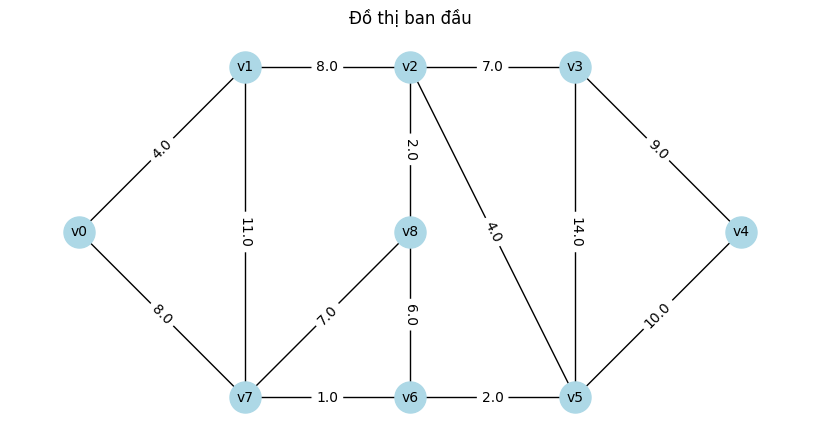

In [ ]:
start_node = "v0"
goal_node = ["v4"]

test_case = GraphProblem(file_path=folder+"/Graph.csv", start_node=start_node, goal_nodes=goal_node)

print("_" * 70)
print("\nDanh sách các node:")
print("_" * 70, end="\n\n")
for i, node in enumerate(test_case.get_nodes()):
    print(f"{i+1})\t{node}")
print()

print("_" * 70)
print("\nDanh sách các cạnh:")
print("_" * 70, end="\n\n")
for i, edge in enumerate(test_case.get_edges()):
    print(f"{i+1})\t{edge}")
print()

# Tạo fixed_positions cho đồ thị
# Hệ tọa độ: (0, 0) nằm ở góc dưới bên trái, (x, y): x là số cột, y là số dòng
fixed_positions = {
    "v0": (0, 1),
    "v1": (1, 2),
    "v2": (2, 2),
    "v3": (3, 2),
    "v4": (4, 1),
    "v5": (3, 0),
    "v6": (2, 0),
    "v7": (1, 0),
    "v8": (2, 1)
}

test_case.draw_graph(fixed_positions)

# **Tìm đường đi ngắn nhất đến 1 đỉnh / 1 tập hợp các đỉnh**

### **Khi đỉnh đích là 1 đỉnh**

______________________________________________________________________

Đường đi ngắn nhất từ v0 đến v4 là:
v0 -> v7 -> v6 -> v5 -> v4

Chi phí đường đi: 21.0

Thời gian chạy: 0.00025 giây
______________________________________________________________________



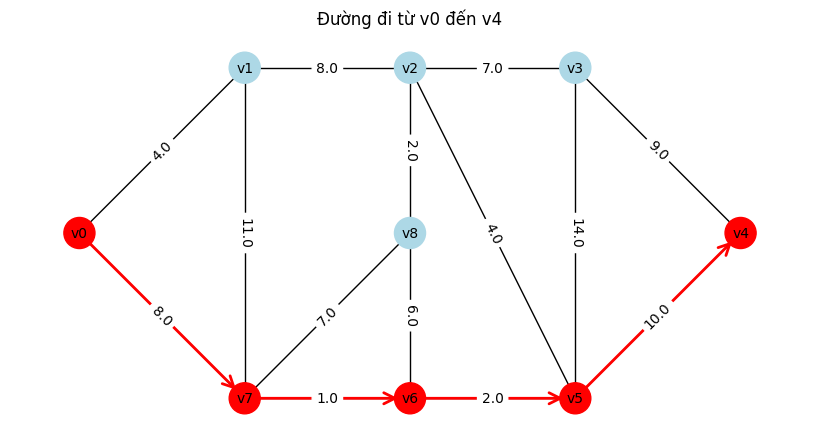

In [ ]:
start_node = "v0"
goal_node = ["v4"]

test_case_1 = GraphProblem(file_path=folder+"/Graph.csv", start_node=start_node, goal_nodes=goal_node)

print("_" * 70)
print(f"\nĐường đi ngắn nhất từ {start_node} đến {goal_node[0]} là:")

start_time = time.time()
path, cost = test_case_1.dijkstra()
end_time = time.time()

print(*path, sep=' -> ')
print()
print(f"Chi phí đường đi: {cost}")
print()
print(f"Thời gian chạy: {end_time - start_time:.5f} giây")
print("_" * 70, end="\n\n")

test_case_1.draw_path(path, fixed_positions)

### **Khi đỉnh đích là 1 tập đỉnh**

*Điều kiện dừng là khi tìm được đường ngắn nhất đến 1 đỉnh bất kỳ trong tập đỉnh*

______________________________________________________________________

Đường đi ngắn nhất từ v0 đến ['v6', 'v2'] là:
v0 -> v7 -> v6

Chi phí đường đi: 9.0

Thời gian chạy: 0.00020 giây
______________________________________________________________________



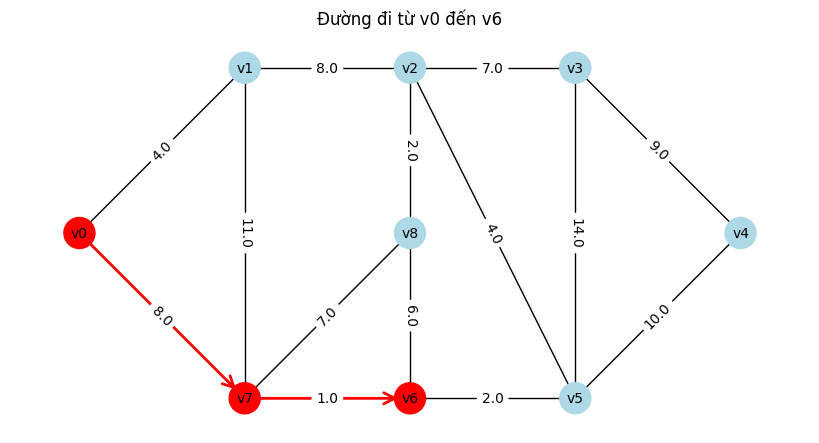

In [ ]:
start_node = "v0"
goal_nodes = ["v6", "v2"]

test_case_2 = GraphProblem(file_path=folder+"/Graph.csv", start_node=start_node, goal_nodes=goal_nodes)

print("_" * 70)
print(f"\nĐường đi ngắn nhất từ {start_node} đến {goal_nodes} là:")

start_time = time.time()
path, cost = test_case_2.dijkstra()
end_time = time.time()

print(*path, sep=' -> ')
print()
print(f"Chi phí đường đi: {cost}")
print()
print(f"Thời gian chạy: {end_time - start_time:.5f} giây")
print("_" * 70, end="\n\n")

test_case_2.draw_path(path, fixed_positions)

# **Tìm đường đi ngắn nhất từ 1 đỉnh đến tất cả các đỉnh còn lại**

In [ ]:
print("_" * 70)
print(f"\nĐường đi ngắn nhất từ {start_node} đến tất cả các đỉnh còn lại:")

start_time = time.time()
all_paths, distances = test_case_1.dijkstra_all_paths()
end_time = time.time()

for node, path in all_paths.items():
    print(f"Đường đi đến {node}: {' -> '.join(str(n) for n in path)}")
    print(f"Khoảng cách: {distances[node]}")
    print("-" * 70)
print(f"Thời gian chạy: {end_time - start_time:.5f} giây")
print("_" * 70)

______________________________________________________________________

Đường đi ngắn nhất từ v0 đến tất cả các đỉnh còn lại:
Đường đi đến v1: v0 -> v1
Khoảng cách: 4.0
----------------------------------------------------------------------
Đường đi đến v7: v0 -> v7
Khoảng cách: 8.0
----------------------------------------------------------------------
Đường đi đến v2: v0 -> v1 -> v2
Khoảng cách: 12.0
----------------------------------------------------------------------
Đường đi đến v3: v0 -> v1 -> v2 -> v3
Khoảng cách: 19.0
----------------------------------------------------------------------
Đường đi đến v5: v0 -> v7 -> v6 -> v5
Khoảng cách: 11.0
----------------------------------------------------------------------
Đường đi đến v8: v0 -> v1 -> v2 -> v8
Khoảng cách: 14.0
----------------------------------------------------------------------
Đường đi đến v4: v0 -> v7 -> v6 -> v5 -> v4
Khoảng cách: 21.0
----------------------------------------------------------------------
Đường đi đế

# **Trường hợp đồ thị có trọng số âm**

In [ ]:
# Khởi tạo tham số với đồ thị Graph_2.csv chứa trọng số âm
start_node = "v0"
goal_node = ["v4"]

test_case_1 = GraphProblem(file_path=folder+"/Graph_2.csv", start_node=start_node, goal_nodes=goal_node)
path, cost = test_case_1.dijkstra()

ValueError: Dijkstra không hoạt động chính xác với đồ thị trọng số âm!

# **Trường hợp đồ thị không liên thông**

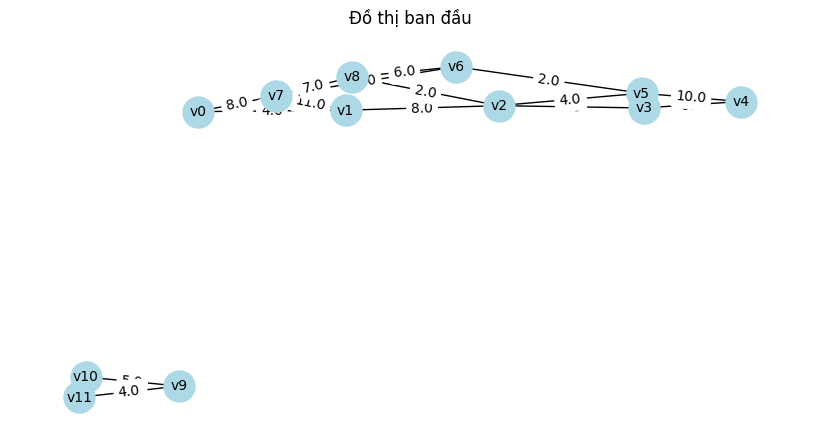

______________________________________________________________________

Đường đi ngắn nhất từ v0 đến v11 là:
None

Chi phí đường đi: inf

Thời gian chạy: 0.00028 giây
______________________________________________________________________

______________________________________________________________________

Đường đi ngắn nhất từ v0 đến "v7" là:
['v0', 'v7']

Chi phí đường đi: 8.0

Thời gian chạy: 0.00017 giây
______________________________________________________________________



In [ ]:
# Khởi tạo tham số với đồ thị Graph_2.csv chứa trọng số âm
start_node = "v0"
goal_node = ["v11"]

test_case_3 = GraphProblem(file_path=folder+"/Graph_3.csv", start_node=start_node, goal_nodes=goal_node)
test_case_3.draw_graph()

print("_" * 70)
print(f"\nĐường đi ngắn nhất từ {start_node} đến {goal_node[0]} là:")

start_time = time.time()
path, cost = test_case_3.dijkstra()
end_time = time.time()

print(path, sep=' -> ')
print()
print(f"Chi phí đường đi: {cost}")
print()
print(f"Thời gian chạy: {end_time - start_time:.5f} giây")
print("_" * 70, end="\n\n")

print("_" * 70)
print(f"\nĐường đi ngắn nhất từ {start_node} đến \"v7\" là:")

test_case_3.start_node = "v0"
test_case_3.goal_nodes = ["v7"]

start_time = time.time()
path, cost = test_case_3.dijkstra()
end_time = time.time()

print(path, sep=' -> ')
print()
print(f"Chi phí đường đi: {cost}")
print()
print(f"Thời gian chạy: {end_time - start_time:.5f} giây")
print("_" * 70, end="\n\n")

---
# **Chạy thuật toán trên đồ thị tạo ngẫu nhiên**

---

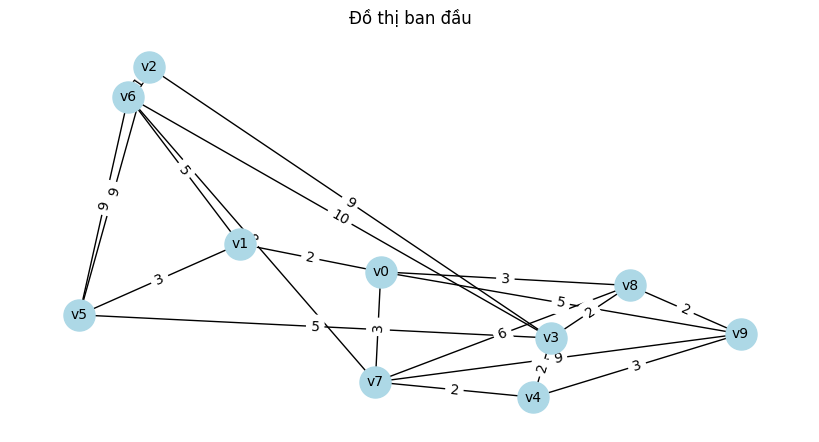

'v8'

In [ ]:
graph = GraphProblem.generate_graph(num_nodes=10, num_edges=20)
graph.draw_graph()
graph.start_node # start_node ban đầu được chọn ngẫu nhiên

Đường đi ngắn nhất từ v2 đến v9 là:
v2 -> v6 -> v1 -> v0 -> v9

Chi phí đường đi: 13


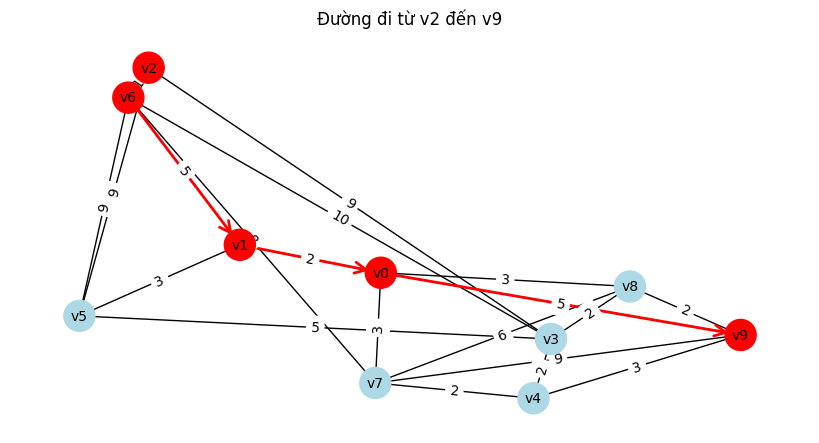

In [ ]:
graph.start_node = "v2"
graph.goal_nodes = ["v9"]
path, cost = graph.dijkstra()
print(f"Đường đi ngắn nhất từ {graph.start_node} đến {graph.goal_nodes[0]} là:")
print(*path, sep=' -> ')
print()
print(f"Chi phí đường đi: {cost}")
graph.draw_path(path)

# **Thời gian chạy thuật toán Dijkstra theo số lượng đỉnh**

---
**Hàm đo thời gian chạy trung bình 100 lần theo số lượng đỉnh**

---

In [ ]:
def measure_time_with_increasing_nodes(num_nodes_list, num_edges_factor=2, num_runs=100):
    """
    Đo lường thời gian chạy trung bình của thuật toán Dijkstra với số lượng node tăng dần.

    """
    average_times = []

    for num_nodes in num_nodes_list:
        times_for_node_count = []

        for _ in range(num_runs):
            graph = GraphProblem.generate_graph(num_nodes=num_nodes, num_edges=num_nodes * num_edges_factor)

            # Start the timer
            start_time = time.time()

            # Run Dijkstra's algorithm
            shortest_path, shortest_distance = graph.dijkstra_all_paths()

            # End the timer
            end_time = time.time()

            # Calculate elapsed time and add to total time
            elapsed_time = end_time - start_time
            times_for_node_count.append(elapsed_time)

        average_time = np.mean(times_for_node_count)
        average_times.append(average_time)

        print(f"Nodes: {num_nodes}, Average Time: {average_time:.6f} seconds")

    return average_times

num_nodes_list = range(10, 101, 10)  # List các số đỉnh cần kiểm tra
execution_times = measure_time_with_increasing_nodes(num_nodes_list)

Nodes: 10, Average Time: 0.000087 seconds
Nodes: 20, Average Time: 0.000204 seconds
Nodes: 30, Average Time: 0.000339 seconds
Nodes: 40, Average Time: 0.000578 seconds
Nodes: 50, Average Time: 0.000891 seconds
Nodes: 60, Average Time: 0.001146 seconds
Nodes: 70, Average Time: 0.001531 seconds
Nodes: 80, Average Time: 0.001944 seconds
Nodes: 90, Average Time: 0.002286 seconds
Nodes: 100, Average Time: 0.002850 seconds
